In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [90]:
data = pd.read_csv("Iris.csv")
# data = data.sample(frac=1)

In [91]:
feature_columns = data.columns[:4]
feature_columns

Index(['Sepal_Length', 'Sepal_Width', 'Petal_Length', 'Petal_Width'], dtype='object')

In [92]:
def normalize(df):
    new_df = df.copy()
    for col in feature_columns:
        new_df[col] -= df[col].mean()
        new_df[col] /= df[col].std()
    return new_df

In [93]:
data_normalized = normalize(data)

In [94]:
categories = np.unique(data["Class"])
colors = ['red', 'yellow', 'blue']
colordict = dict(zip(categories, colors))  

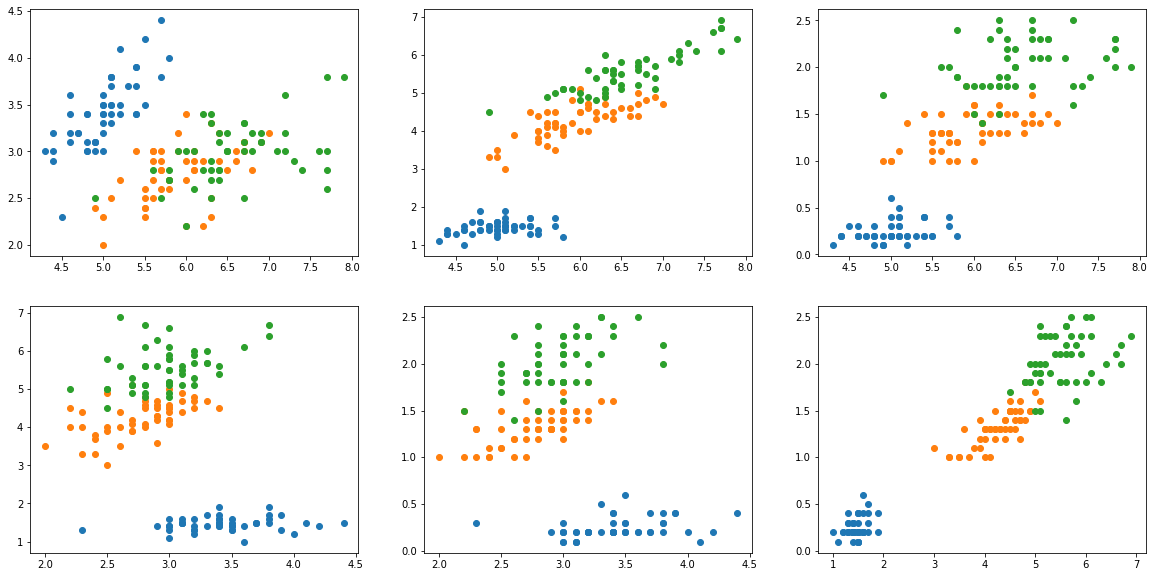

In [95]:
fig, axes = plt.subplots(2,3, figsize=(20,10))
axes = axes.flat
groups = data.groupby("Class")
columns = data.columns
plot_columns = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]

for i,p in enumerate(plot_columns):
    for name, group in groups:
        axes[i].plot(group[columns[p[0]]], group[columns[p[1]]], marker="o", linestyle="", label=name)

In [96]:
def train_test_splitter(data_to_split):
    np.random.seed(1)
    class_1_data = data_to_split[data_to_split['Class'] == categories[0]]
    class_2_data = data_to_split[data_to_split['Class'] == categories[1]] 
    class_3_data = data_to_split[data_to_split['Class'] == categories[2]]
    class_data = [class_1_data, class_2_data, class_3_data]

    classes_train_data = []
    classes_test_data = []
    for data in class_data:
        mask = np.random.rand(len(data)) < 0.8
        classes_train_data.append(data[mask])
        classes_test_data.append(data[~mask])
    train_data = pd.concat(classes_train_data)
    test_data = pd.concat(classes_test_data)
    return(train_data, test_data)

train_data , test_data = train_test_splitter(data)
train_data_normalized, test_data_normalized = train_test_splitter(data_normalized)

In [97]:
class_idx = {}
for i,c in enumerate(categories):
    class_idx[c] = i
class_idx

{'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

In [98]:
train_data.loc[0]

Sepal_Length            5.1
Sepal_Width             3.5
Petal_Length            1.4
Petal_Width             0.2
Class           Iris-setosa
Name: 0, dtype: object

In [99]:
conf_mtx = np.zeros((3,3))
corrects = 0
for i, _ in test_data.iterrows():
    
    diffs = train_data.loc[:, feature_columns] - test_data.loc[i, feature_columns].squeeze(0)
    nearest_index = diffs.pow(2).sum(axis=1).idxmin()
    
    prediction = train_data.loc[nearest_index, 'Class']
    real_class = test_data.loc[i, 'Class']
    
    conf_mtx[class_idx[prediction]][class_idx[real_class]] += 1

    if prediction == test_data.loc[i, 'Class']:
        corrects += 1
        
print(corrects/len(test_data))

0.967741935483871


In [100]:
conf_mtx

array([[10.,  0.,  0.],
       [ 0.,  8.,  0.],
       [ 0.,  1., 12.]])

In [101]:
conf_mtx = np.zeros((3,3))
corrects = 0
for i, _ in test_data_normalized.iterrows():
    diffs = train_data_normalized.loc[:, feature_columns] - test_data_normalized.loc[[i], feature_columns].squeeze(0)
    nearest_index = diffs.pow(2).sum(axis=1).idxmin()
    prediction = train_data_normalized.loc[nearest_index, 'Class']
    real_class = test_data_normalized.loc[i, 'Class']
    conf_mtx[class_idx[prediction]][class_idx[real_class]] += 1
    if prediction == test_data_normalized.loc[i, 'Class']:
        corrects += 1
print(corrects/len(test_data_normalized))

0.9032258064516129


In [82]:
conf_mtx

array([[10.,  0.,  0.],
       [ 0.,  9.,  1.],
       [ 0.,  0., 11.]])

In [83]:
conf_mtx.sum(axis=0)

array([10.,  9., 12.])

In [84]:
precisions = []
recalls = []
f1 = []

In [85]:
for i in range(len(categories)):
    precision = conf_mtx[i][i] / conf_mtx.sum(axis=1)[i]
    precisions.append(precision)
    recall = conf_mtx[i][i] / conf_mtx.sum(axis=0)[i]
    recalls.append(recall)
    f1.append(2 * (precision * recall) / (precision + recall))

In [86]:
precisions

[1.0, 0.9, 1.0]

In [87]:
recalls

[1.0, 1.0, 0.9166666666666666]

In [88]:
f1

[1.0, 0.9473684210526316, 0.9565217391304348]

# Using Sklearn

In [36]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.neighbors import KNeighborsClassifier

In [37]:
X = data[feature_columns]
y = data['Class']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [39]:
knn = KNeighborsClassifier(n_neighbors=1)

In [41]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [46]:
knn.score(X_test, y_test)

1.0

In [45]:
data_normalized = normalize(data)
X = data_normalized[feature_columns]
y = data_normalized['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

1.0

In [48]:
data.sample(frac=1)

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Class
131,7.9,3.8,6.4,2.0,Iris-virginica
82,5.8,2.7,3.9,1.2,Iris-versicolor
81,5.5,2.4,3.7,1.0,Iris-versicolor
115,6.4,3.2,5.3,2.3,Iris-virginica
73,6.1,2.8,4.7,1.2,Iris-versicolor
...,...,...,...,...,...
141,6.9,3.1,5.1,2.3,Iris-virginica
130,7.4,2.8,6.1,1.9,Iris-virginica
28,5.2,3.4,1.4,0.2,Iris-setosa
72,6.3,2.5,4.9,1.5,Iris-versicolor


In [49]:
data

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
